In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import tqdm

import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/vae_celeba_homoscedastic_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/Homoscedastic_CelebA_Vae/0909_191325/checkpoint_99.ckpt")

Missing logger folder: saved/log/Homoscedastic_CelebA_Vae/0909_211843/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/Homoscedastic_CelebA_Vae/0909_211843 exists and is not empty.
Restoring states from the checkpoint path at saved/models/Homoscedastic_CelebA_Vae/0909_191325/checkpoint_99.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:360: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/Homoscedastic_CelebA_Vae/0909_191325' to '/workspace/shai_hulud/ppc_experiments/saved/models/Homoscedastic_CelebA_Vae/0909_211843', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | importance | Convolu

Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=100` reached.


In [7]:
model.eval()
model.cuda()

LightningSvi(
  (importance): ConvolutionalVae(
    (decoder): FixedVarianceDecoder(
      (mean_network): NLVM(
        (projection_layer): Projection(
          (linear): Linear(in_features=40, out_features=1024, bias=True)
          (deconv1): ConvTranspose2d(4, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
          (linear_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (deconv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (deterministic_layer_1): Deterministic(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (deterministic_l

In [8]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)

In [9]:
x_hats = model.forward(xs, B=len(xs), P=model.num_particles).mean(dim=0)

/usr/local/lib/python3.10/dist-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'X'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


In [10]:
import matplotlib.pyplot as plt

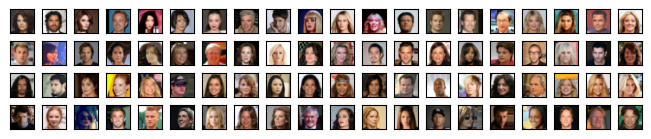

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        orgs = data.reverse_transform(xs[row * 20 + col].detach().cpu()).transpose(0, -1)
        axes[row, col].imshow(orgs)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("vae_celeba_homoskedastic_orgs.pdf", bbox_inches="tight")
plt.show()

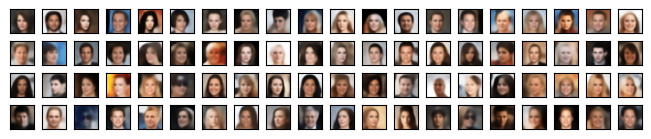

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("vae_celeba_homoskedastic_recons.pdf", bbox_inches="tight")
plt.show()

In [13]:
del x_hats

In [14]:
posterior = {"z": model.importance.encoder(xs).to_event(1).rsample((model.num_particles,))}
x_hats = model.importance.predict(xs, B=xs.shape[0], P=model.num_particles, **posterior)
x_hats = torch.flatten(x_hats, 0, 1)

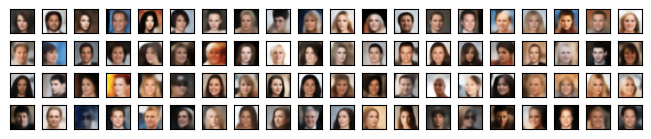

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].squeeze().detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("vae_celeba_homoskedastic_predictive.pdf", bbox_inches="tight")
plt.show()

In [16]:
del x_hats

In [17]:
x_hats = model.forward(xs, B=64, mode="prior", P=model.num_particles)
x_hats = x_hats.flatten(0, 1)

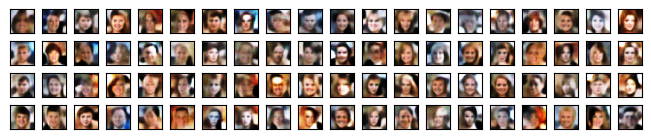

In [18]:
fig, axes = plt.subplots(nrows=4, ncols=20, sharex="all", sharey="all", layout="compressed")

for row in range(4):
    for col in range(20):
        estimates = data.reverse_transform(x_hats[row * 20 + col].squeeze().detach().cpu()).transpose(0, -1).clamp(0, 1)
        axes[row, col].imshow(estimates)
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("vae_celeba_homoskedastic_prior.pdf", bbox_inches="tight")
plt.show()

In [19]:
del x_hats

In [20]:
fids = []
metrics = collections.defaultdict(lambda: [])
data.setup("test")

for f in range(10):
    for b, batch in enumerate(tqdm.tqdm(data.test_dataloader(), desc='Test set FIDs')):
        ms = model.test_step(batch, b)
        for k, v in ms.items():
            metrics[k].append(v)
    fids.append(model.metrics['fid'].compute())
    model.metrics['fid'].reset()

fids = torch.stack(fids, dim=0)
fids.mean(), fids.std()

Files already downloaded and verified


Test set FIDs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [01:59<00:00,  1.31it/s]


(tensor(171.5444), tensor(0.0687))

In [21]:
for k, v in metrics.items():
    metrics[k] = torch.tensor(v)

In [22]:
{m: v.mean(dim=-1) for m, v in metrics.items()}

{'ess': tensor(1.0105),
 'log_joint': tensor(-432771.3750),
 'log_marginal': tensor(-429469.4062),
 'loss': tensor(55425348.)}

In [23]:
{m: v.std(dim=-1) for m, v in metrics.items()}

{'ess': tensor(0.0075),
 'log_joint': tensor(21229.2227),
 'log_marginal': tensor(21211.6309),
 'loss': tensor(2729885.2500)}